# Answering Business Questions using SQL and Python

在这个项目中用到的数据库是[Chinook database](https://github.com/lerocha/chinook-database)。Chinook database为SQLite数据库文件，文件名为 `chinook.db`。Chinook数据库有点像迷你版的iTunes商店，其中包含了虚拟数字音乐商店的相关信息。 
Chinook数据库一共由11个表构成，里面存储了数字音乐商店的专辑、歌曲、艺术家信息和该商店的员工、用户信息及用户订购信息。通过查询和提取数据，我将回答以下问题：  
- 美国地区的用户订购情况？
- 该音乐商店员工的业绩情况？
- 各个国家的用户订购情况？
- 订购整张专辑的订单占多少？
- 最受用户欢迎的艺术家是谁？

## 创建函数进行数据的初步探索  
下面将创建3个函数，用来
- 查询数据并将结果以DataFrame的格式返回
- 运行SQL命令，不返回结果
- 查询数据库中存在的所有表（Table）和视图（View）

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define a run_query() function which gets a query as the argument 
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# define a run_command() function which takes a sql command as the argument
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        #conn.isolation_level = None
        conn.execute(c)
        
#define a show_table() function to illustrate all tables and views in the chinook.db
def show_table():
    q =  '''
         SELECT
             name,
             type 
         FROM sqlite_master
         WHERE type IN ('table', 'view');
         '''
    return run_query(q)

In [3]:
show_table()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


可以看到 `chinook.db` 中一共有11个表和1个在下文中创建的视图，表名如上表所示。各个表之间的关系（schema）如下图所示：
![schema](chinook-schema.png)

## 美国地区的用户订购情况分析

In [4]:
album_purchase = '''
WITH track_usa AS
     (
      SELECT il.* FROM invoice_line 'il'
      INNER JOIN invoice 'i' ON i.invoice_id == il.invoice_id
      INNER JOIN customer 'c' ON c.customer_id == i.customer_id
      WHERE c.country == 'USA'
     ) 
SELECT 
     g.name 'genre',
     COUNT(tu.invoice_line_id) 'quantity',
     CAST(COUNT(tu.invoice_line_id) as float)*100 / (SELECT COUNT(*) FROM track_usa) 'percentage (%)'
FROM track_usa 'tu'
INNER JOIN track 't' ON t.track_id == tu.track_id
INNER JOIN genre 'g' ON g.genre_id == t.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''
run_query(album_purchase)

,genre,quantity,percentage (%)
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


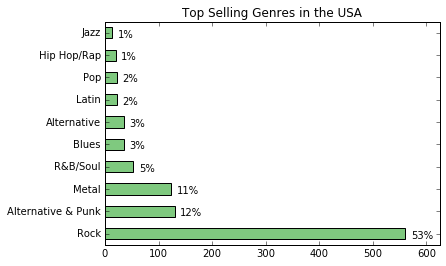

In [5]:
gen_sales_usa = run_query(album_purchase)
gen_sales_usa = gen_sales_usa[:10]
gen_sales_usa.set_index('genre', inplace=True, drop=True)

gen_sales_usa['quantity'].plot.barh( 
                       title = 'Top Selling Genres in the USA',
                       xlim = (0,625),
                       colormap=plt.cm.Accent) #plt.cm是设置color map
plt.ylabel('')

for i, label in enumerate(list(gen_sales_usa.index)): #enumerate函数同时返回索引和值！
    score = gen_sales_usa.loc[label, 'quantity']
    text = (gen_sales_usa.loc[label, 'percentage (%)']).astype(int).astype(str) + '%'
    plt.annotate(str(text),(score+10, i-0.2))   #plt.annotate加文本

plt.show()

通过对美国地区不同类型音乐订购数量的分析可知，在美国地区订购量前三的音乐类型分别是:
- Rock
- Punk
- Metal


其中Rock的订购量非常大，占据了53%的订购量。   

所以，如果该音乐商店准备采购新的专辑，在给出的四位候选人中，应该选择：Red Tone(Punk), Slim Jim Bites(Blues), Meteor and the Girls(Pop)。

## 该音乐商店员工的业绩情况分析

In [6]:
employee_performance = '''
    SELECT 
        e.first_name||' '||e.last_name 'employee name',
        SUM(i.total) 'total sales'
    FROM employee 'e'
    INNER JOIN customer 'c' ON c.support_rep_id == e.employee_id
    INNER JOIN invoice 'i' ON i.customer_id == c.customer_id
    GROUP BY 1
    ORDER BY 2 DESC;
    '''
run_query(employee_performance)

,employee name,total sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


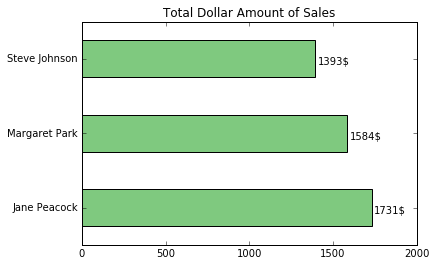

In [7]:
performance = run_query(employee_performance)
performance.set_index('employee name', inplace=True, drop=True)
performance['total sales'].plot.barh(title = 'Total Dollar Amount of Sales',
                                     xlim = (0,2000),
                                    colormap = plt.cm.Accent)
plt.ylabel('')

for i, label in enumerate(list(performance.index)):
    score = performance.loc[label, 'total sales'].astype(int)
    text = str(score) + '$'
    plt.annotate(str(text), (score+15, i-0.08))

plt.show()

通过分析各员工的销售总额可知，3个员工中业绩最好的是Jane Peacock。

## 各个国家的用户订购情况分析

In [8]:
c = '''DROP VIEW country_sales'''
run_command(c)

In [9]:
c = '''
CREATE VIEW country_sales AS
    SELECT
        c.country,
        COUNT(DISTINCT c.customer_id) 'total_customers',
        SUM(il.unit_price) 'total_sales',
        COUNT(DISTINCT i.invoice_id) 'total_order'
    FROM customer 'c'
    INNER JOIN invoice 'i' ON i.customer_id == c.customer_id
    INNER JOIN invoice_line 'il' ON il.invoice_id == i.invoice_id
    GROUP BY 1;
'''
run_command(c)

In [10]:
q = '''select * from country_sales'''
run_query(q)

,country,total_customers,total_sales,total_order
0,Argentina,1,39.60,5
1,Australia,1,81.18,10
2,Austria,1,69.30,9
3,Belgium,1,60.39,7
4,Brazil,5,427.68,61
5,Canada,8,535.59,76
6,Chile,1,97.02,13
7,Czech Republic,2,273.24,30
8,Denmark,1,37.62,10
9,Finland,1,79.20,11


In [11]:
country_purchase = '''
WITH other AS
    (
    SELECT
        CASE
            WHEN total_customers == 1 THEN 'Other'
            ELSE country
            END AS 'country',
        SUM(total_customers) 'total_customers',
        SUM(total_sales) 'total_sales',
        CAST(SUM(total_sales) as float) / SUM(total_customers) 'avg_sales',
        CAST(SUM(total_order) as float) / SUM(total_customers) 'avg_order_numbers'
    FROM country_sales 
    GROUP BY 1
    )
    
SELECT 
    country,
    total_customers,
    total_sales,
    avg_sales,
    avg_order_numbers
FROM                                
    (
     SELECT 
        country,
        total_customers,
        total_sales,
        avg_sales,
        avg_order_numbers,
        CASE 
            WHEN country == 'Other' THEN 1
            ELSE 0
        END AS 'sort'
     FROM other
     ORDER BY 6 ASC, 3 DESC
     )
'''
run_query(country_purchase)  
# order by b, c 两列，先对b排序,然后在第一次排序结果上对第二列排序

,country,total_customers,total_sales,avg_sales,avg_order_numbers
0,USA,13,1040.49,80.037692,10.076923
1,Canada,8,535.59,66.948750,9.500000
2,Brazil,5,427.68,85.536000,12.200000
3,France,5,389.07,77.814000,10.000000
4,Germany,4,334.62,83.655000,10.250000
5,Czech Republic,2,273.24,136.620000,15.000000
6,United Kingdom,3,245.52,81.840000,9.333333
7,Portugal,2,185.13,92.565000,14.500000
8,India,2,183.15,91.575000,10.500000
9,Other,15,1094.94,72.996000,9.800000


注：在分析各个国家的用户订购情况时，注意到有的国家的用户数为1，因此将所有用户数为1 的国家全部归类为Other。一共有15个国家被归为Other。  

上表的结果展示了各个国家的用户数，总订购金额，每位用户的平均订购金额和每位用户的平均订购量。

## 各个国家的用户订购数据可视化

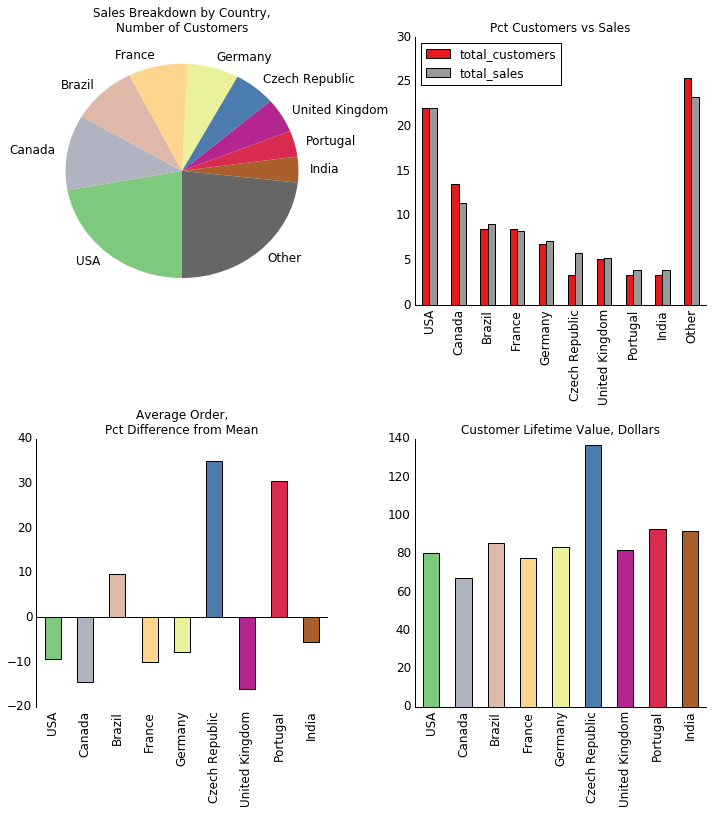

In [12]:
country_metrics = run_query(country_purchase)
country_metrics.set_index('country', drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

#create 2 by 2 figures
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax = ax1,
    startangle = -90,
    counterclock = False,
    title = 'Sales Breakdown by Country,\nNumber of Customers',
    colormap = plt.cm.Accent,
    fontsize = 12,
    wedgeprops = {'linewidth':0} )

# top right
cvd_cols = ['total_customers','total_sales']
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax = ax2,
    colormap = plt.cm.Set1,
    fontsize = 12,
    title = 'Pct Customers vs Sales' )
ax2.tick_params(top='off', right='off', left='off', bottom='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# bottom left
avg_order = country_metrics['avg_order_numbers'].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop('Other', inplace=True)
difference_from_avg.plot.bar(
    ax = ax3,
    color = colors,
    fontsize = 12,
    title = 'Average Order,\nPct Difference from Mean')
ax3.tick_params(top='off', right='off', left='off', bottom='off')
ax3.axhline(0, color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

# bottom right
ltv = country_metrics['avg_sales'].copy()
ltv.index.name = ''
ltv.drop('Other',inplace=True)
ltv.plot.bar(
    ax = ax4,
    color = colors,
    fontsize = 12,
    title = 'Customer Lifetime Value, Dollars')
ax4.tick_params(top='off', right='off', left='off', bottom='off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

基于以上图表，以下3个国家可能有增长潜力：
- Czech Republic
- Portugal
- Brazil

注：由于该数据库的样本数量比较少，所以Marketing团队应该谨慎一点，不要在营销活动上一次性投入太多钱。而应该在这些国家开展小规模的尝试，收集和分析新的用户数据，确保真实情况和当前的分析一致。

## 分析订购整张专辑的订单百分比

In [13]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id 'invoice_id',
         MIN(il.track_id) 'first_track_id'
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) 'number_of_invoices',
    CAST(count(invoice_id) as float) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) 'percent'
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track 't'
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track 't2'
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line 'il2'
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line 'il2'
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track 't'
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track 't2'
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS 'album_purchase'
     FROM invoice_first_track ifs
    )
GROUP BY 1
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


购买整张专辑的订单只占到总订单的18.6%，说明绝大部分的用户都只订购了专辑中的部分作品。  
根据该数据，我建议该音乐商店仅从唱片公司采购专辑中的部分流行作品。

## 分析不同类型的音乐中最受用户欢迎的艺术家

In [14]:
popular_artist = '''
WITH quantity_by_artist AS
    (
     SELECT 
         g.name 'genre',
         a.name 'artist',
         COUNT(il.invoice_id) 'quantity_invoices'
     FROM artist 'a'
     INNER JOIN album 'al' ON al.artist_id == a.artist_id
     INNER JOIN track 't' ON t.album_id == al.album_id
     INNER JOIN genre 'g' ON g.genre_id == t.genre_id
     INNER JOIN invoice_line 'il' ON il.track_id == t.track_id
     GROUP BY 2
    )
SELECT 
    genre,
    artist,
    MAX(quantity_invoices) 'quantity_invoices'
FROM quantity_by_artist
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(popular_artist)

,genre,artist,quantity_invoices
0,Rock,Queen,192
1,Metal,Guns N' Roses,124
2,Alternative & Punk,Green Day,105
3,R&B/Soul,Amy Winehouse,97
4,Latin,Eric Clapton,94
5,Easy Listening,Frank Sinatra,74
6,Jazz,Miles Davis,74
7,Alternative,Chris Cornell,50
8,Hip Hop/Rap,House Of Pain,31
9,Blues,Buddy Guy,23


作品订购数量最多的艺术家即认为是最受用户欢迎的艺术家。通过对每位艺术家作品的用户订购数量进行统计，上表给出了在不同类型的音乐中作品订购数量最多的艺术家的名字及总订购数量。